In [21]:
import os
import glob
import yaml
import matplotlib.pyplot as plt
import cv2
from pathlib import Path
import random


In [22]:
dataset_dir = Path("Yawn_detection.v2i.yolov8")

yaml_path = dataset_dir / "data.yaml"

if not yaml_path.exists():
    raise FileNotFoundError("data.yaml not found! Check your folder name.")

with open(yaml_path, "r") as f:
    data_cfg = yaml.safe_load(f)

data_cfg


{'path': 'Yawn_detection.v2i.yolov8',
 'train': 'Yawn_detection.v2i.yolov8/train/images',
 'val': 'Yawn_detection.v2i.yolov8/valid/images',
 'test': 'Yawn_detection.v2i.yolov8/test/images',
 'names': {0: 'no_yawn', 1: 'yawn'}}

In [23]:
splits = ["train", "valid", "test"]

for split in splits:
    img_dir = dataset_dir / split / "images"
    count = len(list(img_dir.glob("*.jpg"))) + len(list(img_dir.glob("*.png")))
    print(f"{split.upper()} images:", count)


TRAIN images: 13708
VALID images: 1197
TEST images: 628


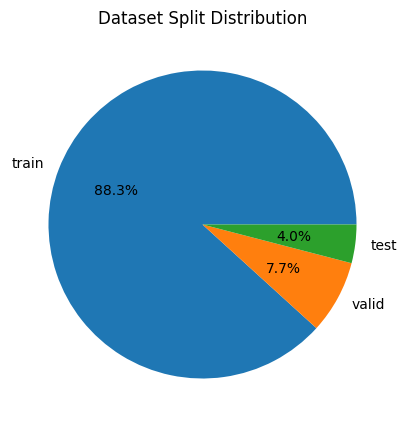

In [24]:
sizes = []
labels = []

for split in splits:
    img_dir = dataset_dir / split / "images"
    count = len(list(img_dir.glob("*.jpg"))) + len(list(img_dir.glob("*.png")))
    sizes.append(count)
    labels.append(split)

plt.figure(figsize=(5,5))
plt.pie(sizes, labels=labels, autopct="%1.1f%%")
plt.title("Dataset Split Distribution")
plt.show()


In [25]:
print("Classes:", data_cfg["names"])
print("Number of classes:", len(data_cfg["names"]))


Classes: {0: 'no_yawn', 1: 'yawn'}
Number of classes: 2


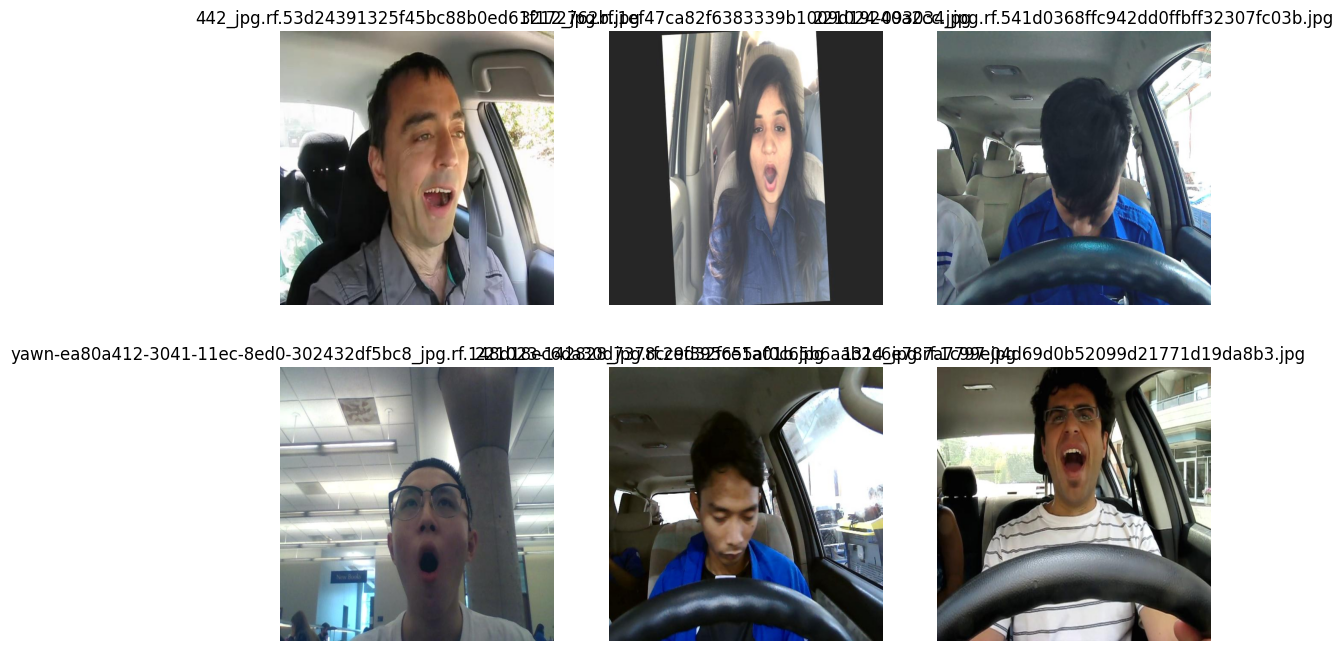

In [26]:
def show_random_images(split="train", n=6):
    img_dir = dataset_dir / split / "images"
    imgs = list(img_dir.glob("*"))

    plt.figure(figsize=(12, 8))

    for i in range(n):
        img_path = random.choice(imgs)
        img = cv2.imread(str(img_path))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        plt.subplot(2, 3, i+1)
        plt.imshow(img)
        plt.title(img_path.name)
        plt.axis("off")

    plt.show()

show_random_images("train")


In [27]:
def draw_yolo_boxes(image_path, label_path):
    img = cv2.imread(str(image_path))
    img_h, img_w = img.shape[:2]

    with open(label_path, "r") as f:
        lines = f.readlines()

    for line in lines:
        cls, x_center, y_center, w, h = map(float, line.split())

        x_center *= img_w
        y_center *= img_h
        w *= img_w
        h *= img_h

        x1 = int(x_center - w/2)
        y1 = int(y_center - h/2)
        x2 = int(x_center + w/2)
        y2 = int(y_center + h/2)

        color = (0,255,0)
        cv2.rectangle(img, (x1,y1), (x2,y2), color, 2)
        cv2.putText(img, data_cfg["names"][int(cls)], (x1, y1-10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)

    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img_rgb)
    plt.axis("off")


In [28]:
# pick one label file
sample_label = next((dataset_dir / "train" / "labels").glob("*.txt"))

print("Label file:", sample_label)

with open(sample_label, "r") as f:
    for line in f.readlines():
        print("RAW:", line)


Label file: Yawn_detection.v2i.yolov8\train\labels\024_G1_07_-_-_-_20200923_193116_02513_jpg.rf.335d6a2c89ac221dadce377f0191a33e.txt
RAW: 1 0.2828125 0.409375 0.66875 0.409375 0.66875 0.7140625 0.2828125 0.7140625


Image: Yawn_detection.v2i.yolov8\train\images\tinh_Nam1_jpg.rf.54a1f13eeafa33268434511fde3a880a.jpg
Label: Yawn_detection.v2i.yolov8\train\labels\tinh_Nam1_jpg.rf.54a1f13eeafa33268434511fde3a880a.txt


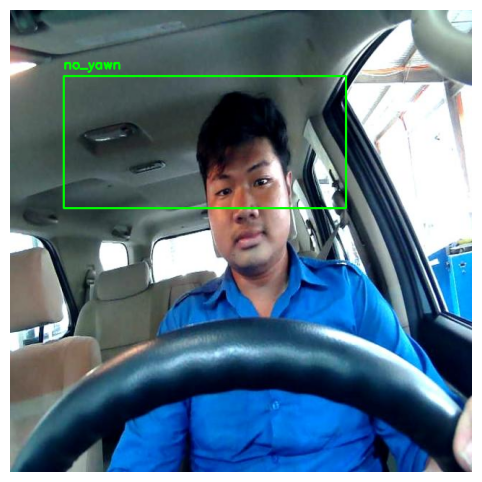

In [29]:
import cv2
import matplotlib.pyplot as plt
import random
from pathlib import Path

# ✅ Draw bounding boxes
def draw_yolo_boxes(image_path, label_path):
    img = cv2.imread(str(image_path))
    img_h, img_w = img.shape[:2]

    with open(label_path, "r") as f:
        lines = f.readlines()

    for line in lines:
        parts = line.split()

        # ✅ Use only first 5 values (class, x_center, y_center, w, h)
        cls, x_center, y_center, w, h = map(float, parts[:5])

        # ✅ Convert relative YOLO coords → absolute pixel coords
        x_center *= img_w
        y_center *= img_h
        w *= img_w
        h *= img_h

        x1 = int(x_center - w/2)
        y1 = int(y_center - h/2)
        x2 = int(x_center + w/2)
        y2 = int(y_center + h/2)

        color = (0,255,0)
        cv2.rectangle(img, (x1, y1), (x2, y2), color, 2)

        # ✅ Put class name
        cv2.putText(img, data_cfg["names"][int(cls)], (x1, y1 - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)

    # ✅ Convert BGR → RGB for plotting
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(8,6))
    plt.imshow(img_rgb)
    plt.axis("off")


def show_random_labeled(split="train"):
    img_dir = dataset_dir / split / "images"
    imgs = list(img_dir.glob("*"))

    while True:
        img_path = random.choice(imgs)
        label_path = dataset_dir / split / "labels" / (img_path.stem + ".txt")

        if not label_path.exists():
            continue

        print("Image:", img_path)
        print("Label:", label_path)

        draw_yolo_boxes(img_path, label_path)
        break  


# ✅ Run it
show_random_labeled("train")


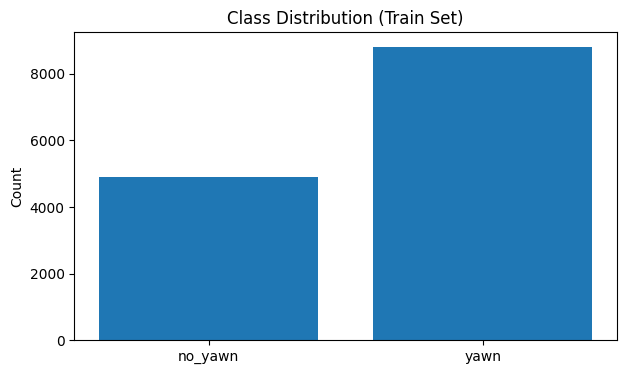

In [30]:
import numpy as np

class_list = [data_cfg["names"][i] for i in range(len(data_cfg["names"]))]

class_count = {cls: 0 for cls in class_list}

label_files = list((dataset_dir / "train" / "labels").glob("*.txt"))

for label_file in label_files:
    with open(label_file, "r") as f:
        for line in f.readlines():
            cls_id = int(line.split()[0])

            if cls_id < 0 or cls_id >= len(class_list):
                continue

            class_name = class_list[cls_id]
            class_count[class_name] += 1

plt.figure(figsize=(7,4))
plt.bar(class_count.keys(), class_count.values())
plt.title("Class Distribution (Train Set)")
plt.ylabel("Count")
plt.show()


In [31]:
# Show image & label counts per split

split_counts = {}

for split in ["train", "valid", "test"]:
    img_count = len(list((dataset_dir / split / "images").glob("*")))
    label_count = len(list((dataset_dir / split / "labels").glob("*")))
    split_counts[split] = (img_count, label_count)

split_counts


{'train': (13708, 13708), 'valid': (1197, 1197), 'test': (628, 628)}

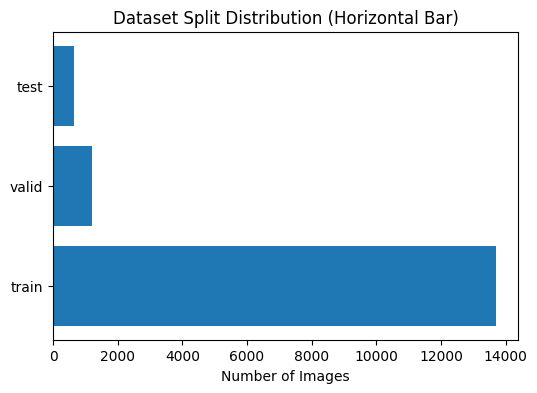

In [32]:
splits = ["train", "valid", "test"]
counts = []

for s in splits:
    img_dir = dataset_dir / s / "images"
    counts.append(len(list(img_dir.glob("*"))))

plt.figure(figsize=(6,4))
plt.barh(splits, counts)
plt.xlabel("Number of Images")
plt.title("Dataset Split Distribution (Horizontal Bar)")
plt.show()


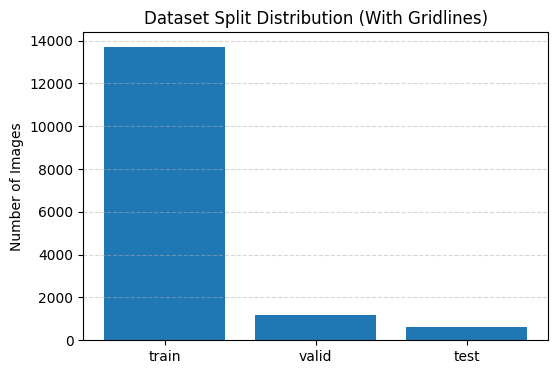

In [33]:
plt.figure(figsize=(6,4))
plt.bar(splits, counts)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.title("Dataset Split Distribution (With Gridlines)")
plt.ylabel("Number of Images")
plt.show()


In [34]:
splits = ["train", "valid", "test"]
total_images = 0

for split in splits:
    img_dir = dataset_dir / split / "images"
    count = len(list(img_dir.glob("*")))
    print(f"{split.upper()} images: {count}")
    total_images += count

print("\nTOTAL IMAGES IN DATASET:", total_images)


TRAIN images: 13708
VALID images: 1197
TEST images: 628

TOTAL IMAGES IN DATASET: 15533


In [35]:
from pathlib import Path
import os

train_img_dir = dataset_dir / "train" / "images"
train_label_dir = dataset_dir / "train" / "labels"

train_images = list(train_img_dir.glob("*"))
train_labels = list(train_label_dir.glob("*.txt"))

# ✅ 1. Total images & label files
num_images = len(train_images)
num_labels = len(train_labels)

# ✅ 2. Images that do NOT have labels
images_without_labels = []

for img in train_images:
    label_path = train_label_dir / (img.stem + ".txt")
    if not label_path.exists():
        images_without_labels.append(img.name)

# ✅ 3. Labels that do NOT have matching images
labels_without_images = []

for lbl in train_labels:
    img_path = train_img_dir / (lbl.stem + lbl.suffix.replace(".txt", ".jpg"))
    png_path = train_img_dir / (lbl.stem + lbl.suffix.replace(".txt", ".png"))
    if not img_path.exists() and not png_path.exists():
        labels_without_images.append(lbl.name)

# ✅ 4. Count total bounding boxes & per-class distribution
class_list = [data_cfg["names"][i] for i in range(len(data_cfg["names"]))]
class_count = {cls: 0 for cls in class_list}
total_bboxes = 0

for lbl in train_labels:
    with open(lbl, "r") as f:
        for line in f.readlines():
            parts = line.split()
            cls_id = int(parts[0])

            if cls_id < 0 or cls_id >= len(class_list):
                continue

            total_bboxes += 1
            class_count[class_list[cls_id]] += 1

# ✅ 5. Average boxes per labeled image
avg_boxes = total_bboxes / max(1, len(train_labels))

# ✅ PRINT RESULTS
print("===== LABEL STATISTICS =====")
print(f"Total train images: {num_images}")
print(f"Total label files: {num_labels}")
print(f"Total bounding boxes: {total_bboxes}")
print(f"Average boxes per labeled image: {avg_boxes:.2f}")

print("\nImages without labels:", len(images_without_labels))
print("Labels without images:", len(labels_without_images))

print("\nBounding boxes per class:")
for cls, cnt in class_count.items():
    print(f"  {cls}: {cnt}")


===== LABEL STATISTICS =====
Total train images: 13708
Total label files: 13708
Total bounding boxes: 13708
Average boxes per labeled image: 1.00

Images without labels: 0
Labels without images: 0

Bounding boxes per class:
  no_yawn: 4904
  yawn: 8804
